# Automatically scrape job postings of a competitor

We will now see scraping in action. Imagine you are working in HR for a major retailer. Your boss asks you to monitor the strategic hiring decisions of your close competitors. Naturally, you cannot go and call them up - but you could take a look at their job postings to see ($i$) how much they are hiring, ($ii$) what types of positions they are hiring for.

Now, you could log onto their website every day, see what job postings there are, compare that with the job postings from before, and save the relevant data. But why go through so much effort if we can just automate the task?

## Using BeautifulSoup

In the first example, we'll scrape data from a simple (read, static) website BeautifulSoup and Requests (and a bit of Pandas!).

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

We are searching for positions in the head office of Aldi. Aldi has a dedicated website for these positions, https://www.aldirecruitment.co.uk/head-office. We request the HTML document at this address and parse it with BeautifulSoup:

In [ ]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

We see that there are different types of head office positions, each with their own website. Let's get the links to those sub-sites.

To do so, we note the structure of HTML documents. Everything is embedded within tags, which confer meaning (e.g., "li" tags to signify list elements, or "div" tags to signify sections within the document). We focus on "a"-tags: all links in an HTML document (to other HTML documents) appear within those tags. Let's `.find()` ourselves an "a"-tag with BeautifulSoup:

In [ ]:
soup.find('a')

This returns the first tag in the HTML document. But we want to find all of them, so we use `.findAll()`.

In [ ]:
a_tags = soup.findAll('a')
a_tags

We see that there are a lot of tags. Importantly, the ones that actually link to other sites will contain something along the lines of `href="link"`. `href` is an attribute of the "a"-tag. In particular, it contains the link that you will follow when clicking on the HTML document where the "a"-tag is located. When we have found an HTML tag in BeautifulSoup, we can access its attributes with `.get("attribute_name")`. Now, we are ready to collect the links from the "a"-tags:

In [ ]:
links = []
for a in a_tags:
    links.append(a.get('href'))
print(links)

We want to get only the links to actual job postings, so we have to clean the results somewhat. First, we eliminate any link that is `None` (this is the link when the "a"-tag doesn't actually have an href attribute, as in the first case:

In [ ]:
new_links = []
for link in links:
    if link != None:
        new_links.append(link)
links = new_links
print(links)

Next, we have to find the links that we actually care for (the links to the departments in which positions are posted). Analyzing the HTML document, we find that all these links start with "/head-office/". So let's only keep links that start like this:

In [ ]:
new_links = []
for link in links:
    if link.startswith('/head-office/'):
        new_links.append(link)
links = new_links
print(links)

A final correction: there is one link that refers to the website itself ('/head-office/'). We don't need to consider this one:

In [ ]:
new_links = []
for link in links:
    if link != '/head-office/':
        new_links.append(link)
links = new_links
print(links)

We can now put everything together:

In [ ]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
links = []
for link in soup.findAll('a'):
    new_link = link.get('href')
    if new_link != None and new_link.startswith('/head-office/') and new_link != '/head-office/':
        links.append(new_link)
print(links)

So how to we access the department websites now? The links we got are relative to the domain (https://www.aldirecruitment.co.uk). Hence, to access any one of the websites, we use a combination of this domain, together with the link we just extracted. For example:

In [ ]:
category_url = "https://www.aldirecruitment.co.uk" + links[0]
page = requests.get(category_url)
print("We are extracting the website " + category_url)
print("It contains the following HTML document:")
soup = BeautifulSoup(page.content, "html.parser")
print(soup)

We've made it to one of the subsites. Postings can be found throughout the site in little dropdown menus. So how to find the dropdown menus? This is where inspecting the HTML really comes in. When inspecting the dropdown windows, you will see something like this:
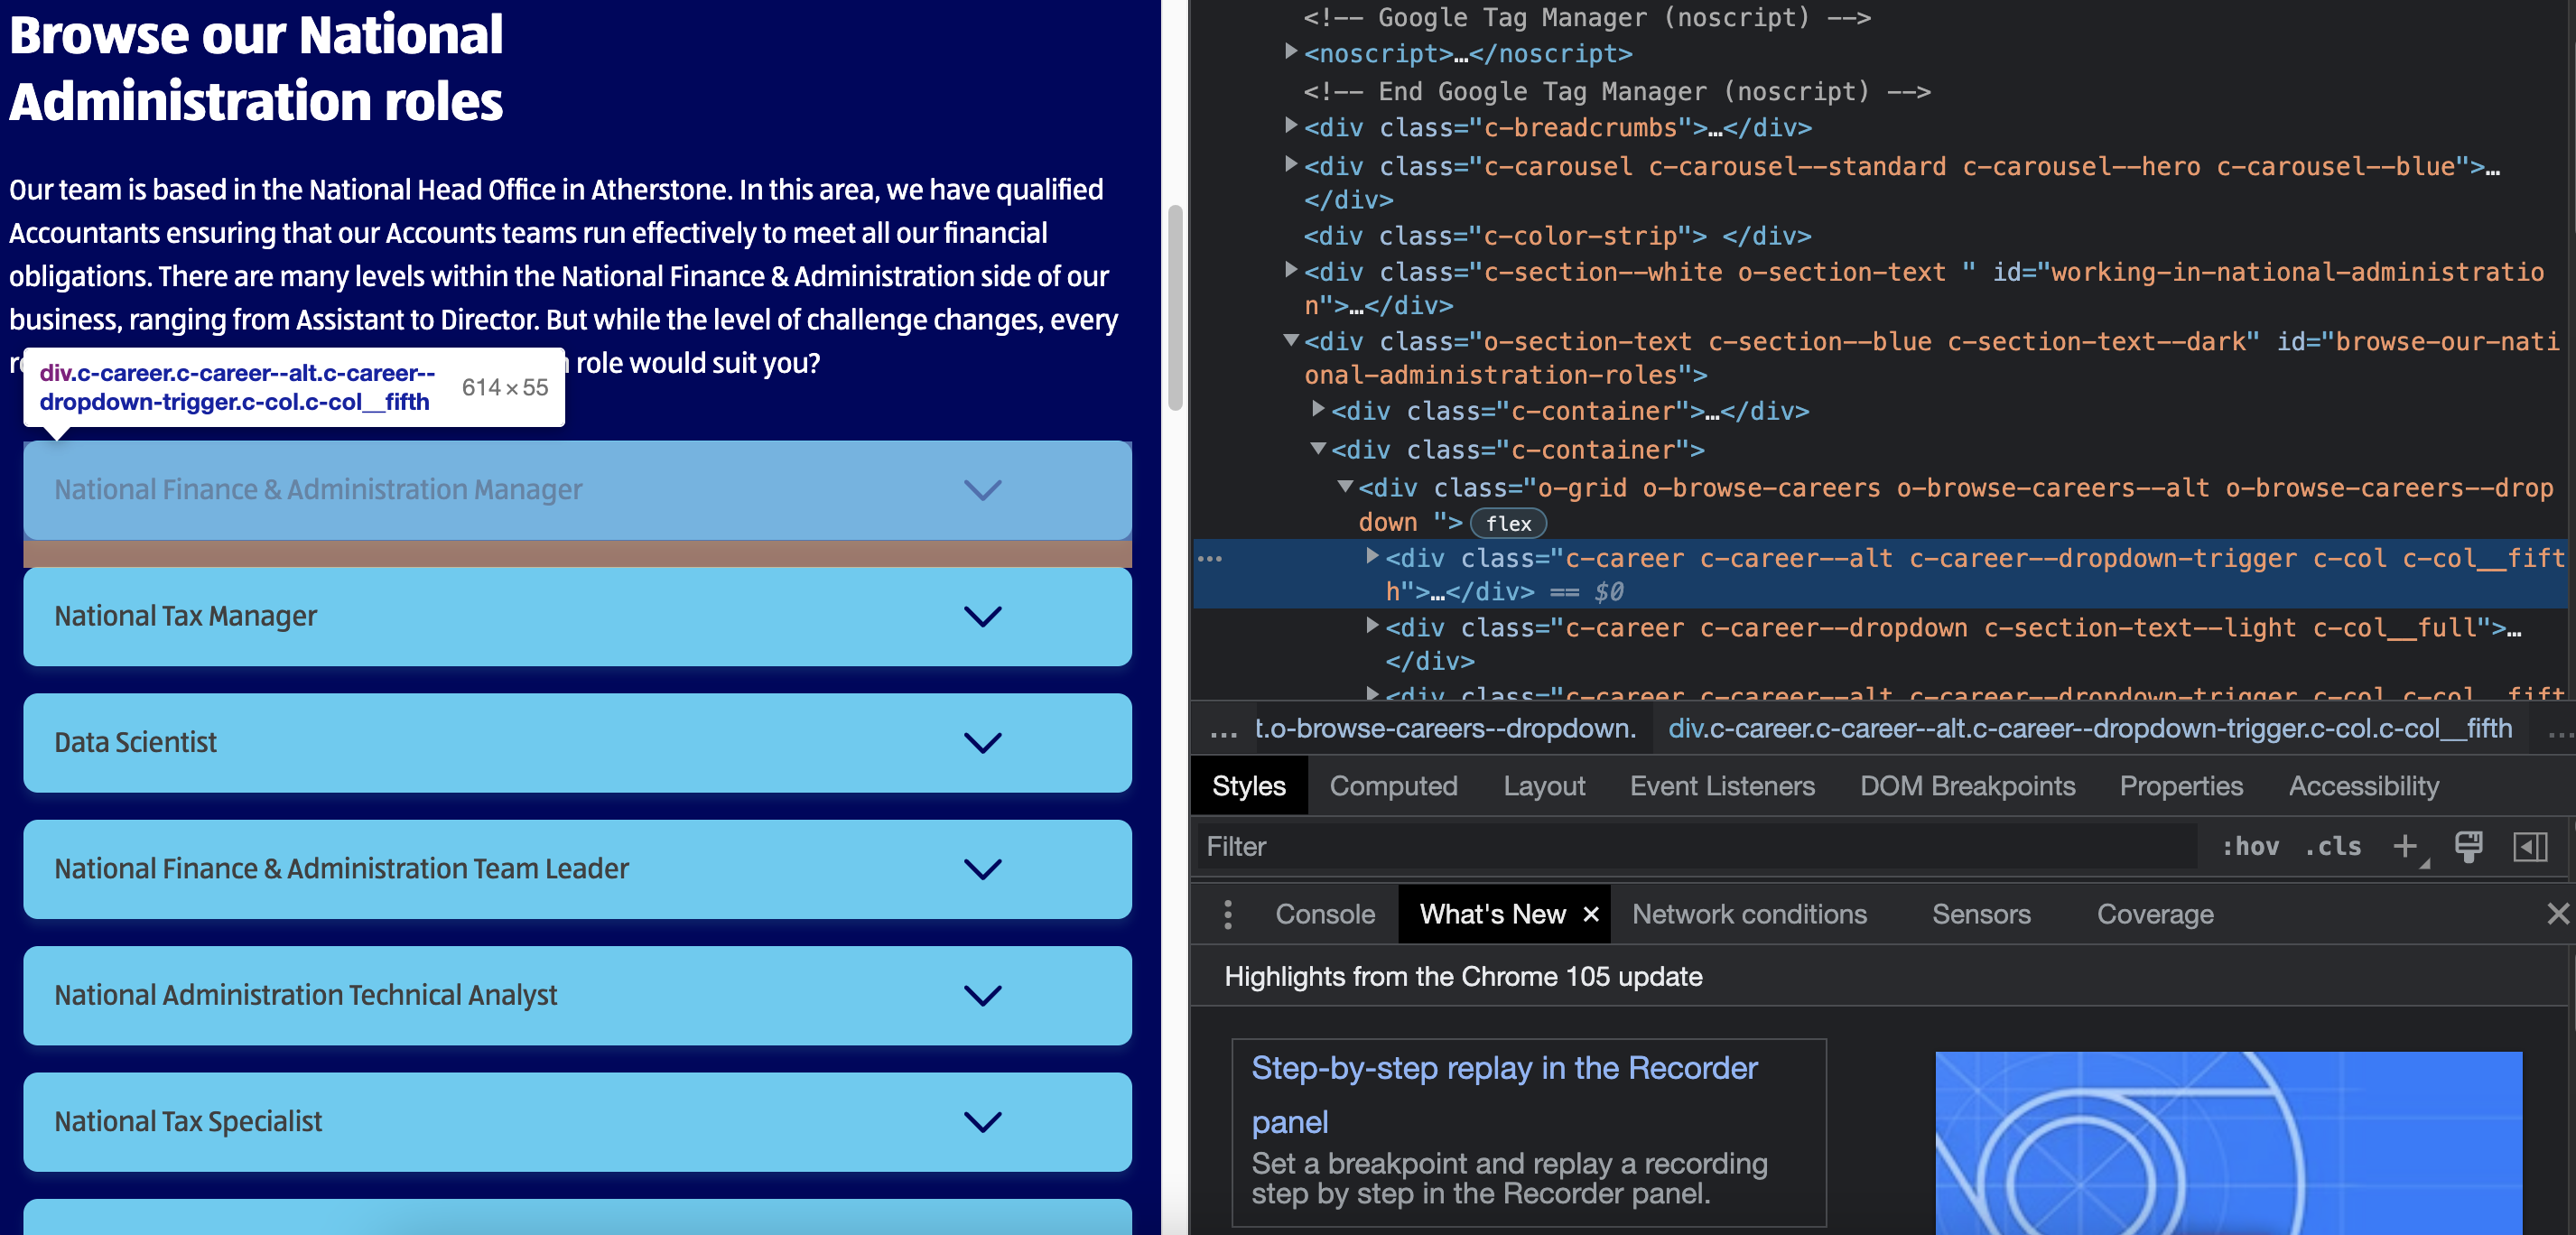

There are a bunch of "div" tags, that contain the relevant information. These tags list a class attribute (with multiple classes defined). We can make use of these attributes to find the right tags.

Take the first tag: it has the classes "c-career", "c-career--alt", "c-career--dropdown-trigger", "c-col", and "c-col__fifth". Note that the next tag has overlapping classes, but not exactly the same: "c-career", "c-career--dropdown", "c-section-text--light", and "c-col__full". What's the difference between these tags? Let's insepct and see:

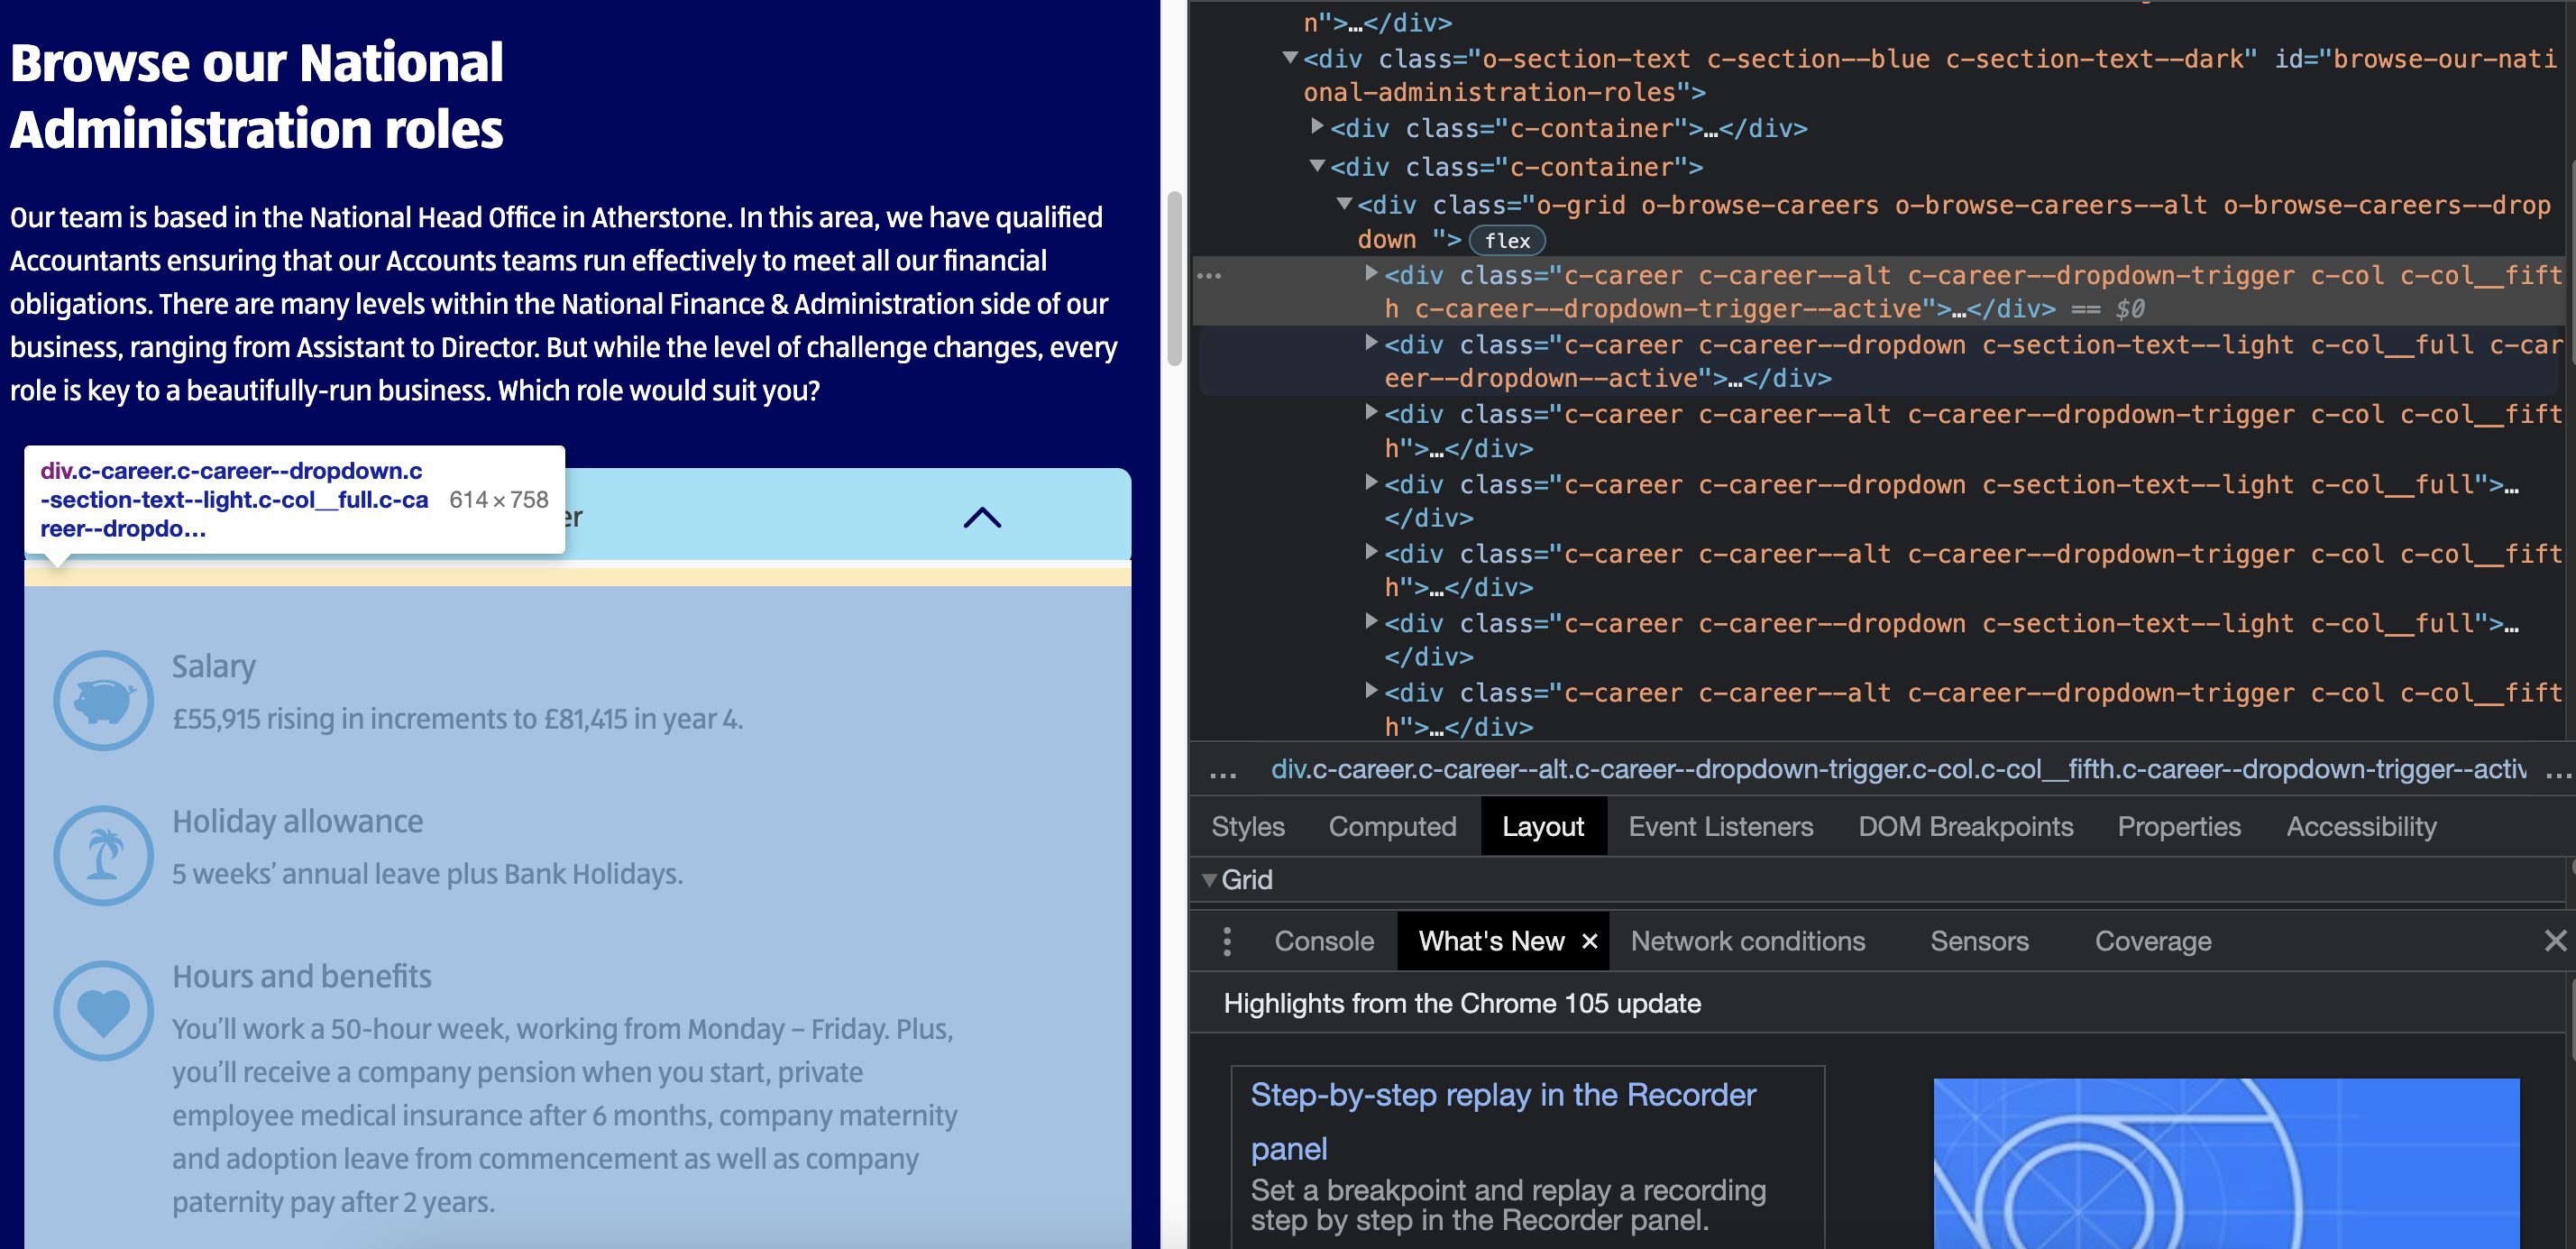

When we open the posting, we see that the second tag changes a little bit (it now also has the tag "c-career--dordown__active"). What we can find is that the relevant information is actually here (everything that gets dropped down). Luckily, the information is in the HTML even without opening the posting through clicking (open up the second tag to verify this!)

Playing with the inspection tool in this manner, we can soon see that the list of postings is structured as follows: one "div" tag that contains the heading on which you can click, and one "div" tag that contains the actual posting.

Now, of course, we could search for all the "div" tags with BeautifulSoup:

In [ ]:
div_tags = soup.findAll("div")
len(div_tags)

There are a lot of div tags, many more than postings. Luckily, we can use the different class attributes to specify our search. Let's start with the most obvious class, "c-career":

In [ ]:
div_tags = soup.findAll("div", class_="c-career")
len(div_tags)

There are still too many. Why? Because every posting comes with two sets of "div"-tags. So let's be more specific. The button-tag will always have class "c-career--dropwdown-trigger", but only the content tag will have "c-career--dropdown" (again, inspection is key:)

In [ ]:
div_tags = soup.findAll("div", class_="c-career--dropdown")
len(div_tags)

It seems we have found our posting! Let's verify:

In [ ]:
print(div_tags)

Of course, the actual information is still at lower layers. Let's focus on the first posting for now:

In [ ]:
posting = div_tags[0]
print(posting)

To find, for example, the job title, we can again use inspection. We see that the title is within a "h2"-tag, which is a type of header tag. Let's search this tag within the posting:

In [ ]:
posting.find('h2')

Note that we don't want to include the tags themselves, but only the text:

In [ ]:
posting.find('h2').text

Aside from the title and the text description (which we will ignore in this example, but which can hold extremely useful information), there are some key details about the job, such as the work time and the salary. The posting contains a little table. Again, we can use inspection to find what we are looking for.

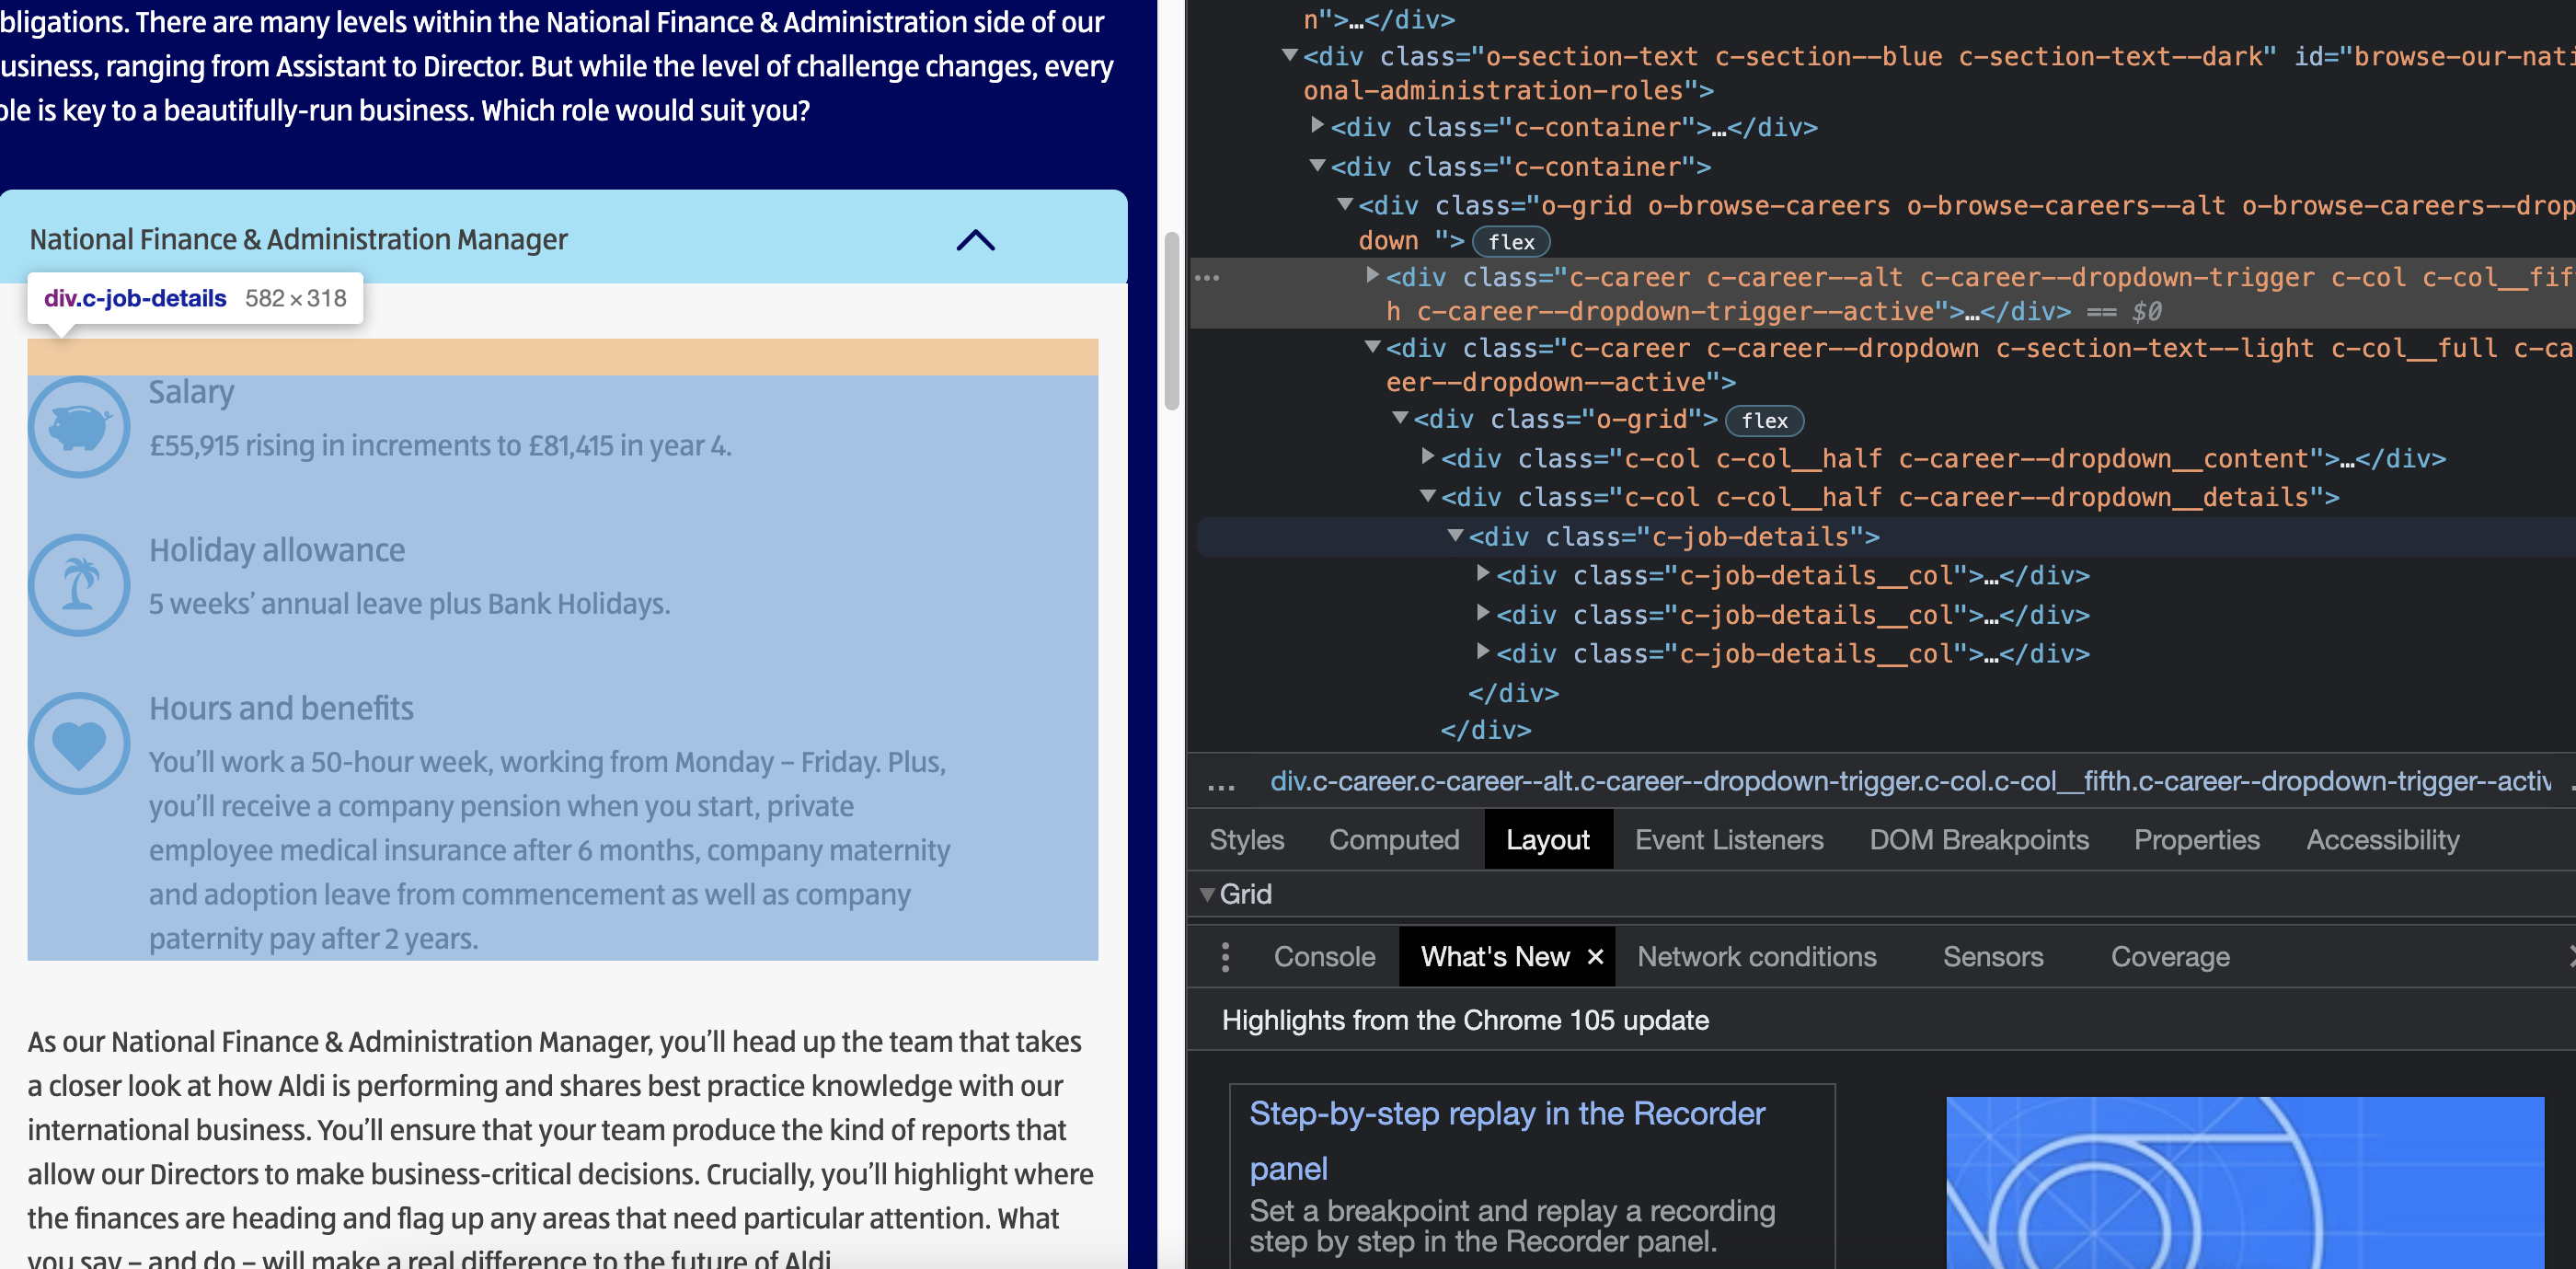

We see that the information here is contained in "div" tags of the class "c-job-details__col". In this case, there are three of these tags. Let's find them with BeautifulSoup:

In [ ]:
details = posting.findAll("div", class_="c-job-details__content")
print(details)

We definitely want to get the salary information. This is within the first tag, in another div tag. To identify that div tag, we again use the class: "c-job-details__text":

In [ ]:
salary_detail = details[0]
salary_text = salary_detail.find('div', class_="c-job-details__text").text
print(salary_text)

The text gives multiple values, so let's make sure to save the lowest and the highest value (of course, multiple values may be due to changes over time or for different starting requirements - we can adapt our scraper to capture arbitrary complexity later on). We start by splitting the sentence into words:

In [ ]:
word_list = salary_text.split()
print(word_list)

We now analyze whether we find any numbers here. Note that numbers start with the £-sign.

In [ ]:
number_content = [s for s in word_list if s.startswith('£')]
print(number_content)

Note the use of "," as a separator - we may not be able to convert the number with this. What we do is remove the £ sign and the comma, before converting the numbers to floats:

In [ ]:
numbers_formatted = []
for number in number_content:
    number = number.replace(',','')
    number = number.replace('£','')
    number = float(number)
    numbers_formatted.append(number)
print(numbers_formatted)

Now that we have the values as numbers, we can find the lower and the upper bound on the salary:

In [ ]:
ub = max(numbers_formatted)
lb = min(numbers_formatted)
print(ub)
print(lb)

We're done with salary. Let's also try to capture the weekly working hours. These are in the last job-detail div (and again, inside the div tag with class-attribute "c-job-details__text"):

In [ ]:
hour_detail = details[2]
hour_text = hour_detail.find('div', class_="c-job-details__text").text
print(hour_text)

The actual hours are indicated with "X-hour week". So let's find a string that looks like this (we first split the string into individual words):

In [ ]:
words = hour_text.split()
for word in words:
    if '-hour' in word:
        work_time = int(word.replace('-hour',''))
print(work_time)

The following code combines our extraction of job details in a function. We only adjust one aspect: instead for taking the first detail to be the salary and the third to be the hours, we actually check the title to see which one is which (this information is in a "span"-tag with class "c-jobs-details__title").

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title) # To see where possible possible errors are, we add a print out
    details = posting.findAll("div", class_="c-job-details__content")
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary': # To avoid issues with capitalization, we use lower case on the detail title
            word_list = detail_text.split()
            number_content = [s for s in word_list if s.startswith('£')]
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            ub = max(numbers_formatted)
            lb = min(numbers_formatted)
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word:
                    work_time = int(word.replace('-hour',''))
    return job_title, lb, ub, work_time

Let's try with the first posting:

In [ ]:
posting = div_tags[0]
job_title, lb, ub, work_time = extract_posting_details(posting)

print(job_title)
print(ub)
print(lb)
print(work_time)

Let's now go through all postings on the subpage (if you get an error, this is normal!):

In [ ]:
i = 1
for posting in div_tags:
    print("Posting number " + str(i))
    job_title, lb, ub, work_time = extract_posting_details(posting)
    print("Job title: " + str(job_title))
    print("Salary upper bound: " + str(ub))
    print("Salary lower bound: " + str(lb))
    print("Work time: " + str(work_time))
    print("-----")
    i += 1

Where is the error coming from? There are cases without a number of hours or salary values. We adjust our code to make sure there is no error:

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title)
    details = posting.findAll("div", class_="c-job-details__content")
    ub = "not found" # Ensure that, even if the salary is not found, something is returend
    lb = "not found" # Ensure that, even if the salary is not found, something is returend
    work_time = "not found" # Ensure that, even if the work hours are not found, something is returend
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary': # To avoid issues with capitalization, we use lower case on the detail title
            word_list = detail_text.split()
            number_content = [s for s in word_list if s.startswith('£')]
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            if len(numbers_formatted) > 0: # We can only find a max and min salary if any numbers have been found
                ub = max(numbers_formatted)
                lb = min(numbers_formatted)
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word:
                    work_time = int(word.replace('-hour',''))
    return job_title, lb, ub, work_time

Let's try again:

In [ ]:
i = 1
for posting in div_tags:
    print("Posting number " + str(i))
    job_title, lb, ub, work_time = extract_posting_details(posting)
    print("Job title: " + str(job_title))
    print("Salary upper bound: " + str(ub))
    print("Salary lower bound: " + str(lb))
    print("Work time: " + str(work_time))
    print("-----")
    i += 1

Now that we have all the information from one page, let's collect the information from all the subpages. To do so, we create another function, that iterates through all the pages, and all the postings within the pages:

In [ ]:
def scrape_aldi_headoffice_jobs():
    # We create lists of all the posting information we care about
    departments = []
    titles = []
    ubs = []
    lbs = []
    times = []
    
    # Start by getting all the urls of the subpages
    url = "https://www.aldirecruitment.co.uk/head-office/"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = []
    for link in soup.findAll('a'):
        new_link = link.get('href')
        if new_link != None and new_link.startswith('/head-office/') and new_link != '/head-office/':
            links.append(new_link)

    # Follow each of the subpage links
    for link in links:
        category_url = "https://www.aldirecruitment.co.uk" + link
        print("Scraping url: " + category_url) # We add another print-out to debug
        page = requests.get(category_url)
        # Parse the subpage
        soup = BeautifulSoup(page.content, "html.parser")
        
        # Find the name of the subpage (the links is the department name, which gives relevant information - we just need to clean it up a bit)
        # We simly take out the "/head-office/" part and the final /, as well as any dashed in-between
        department = link.replace("/head-office/","")
        department = department.replace("/","")
        department = department.replace("-"," ")

        # Find all the "div"-tags with class-attribute "c-career--dropdown" (these are the job postings):
        div_tags = soup.findAll("div", class_="c-career--dropdown")
        
        # Parse each of the job postings, using our previous function:
        for posting in div_tags:
            job_title, lb, ub, work_time = extract_posting_details(posting)
            # We add these to our lists:
            titles.append(job_title)
            lbs.append(lb)
            ubs.append(ub)
            times.append(work_time)
            # We also add the department information
            departments.append(department)
            
    # Finally, we convert our information into a data frame:
    job_data = pd.DataFrame(
        {'Department': departments,
         'Job title': titles,
         'Salary lower': lbs,
         'Salary upper': ubs,
         'Weekly hours': times
        })
    return job_data

Let's try it out (again, don't be surprised if there is an error here)

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()

Depending on when you scrape this, you might observe different errors. We will look at fixing those by redefining our extraction function. At the time of writing, I find the following issues:

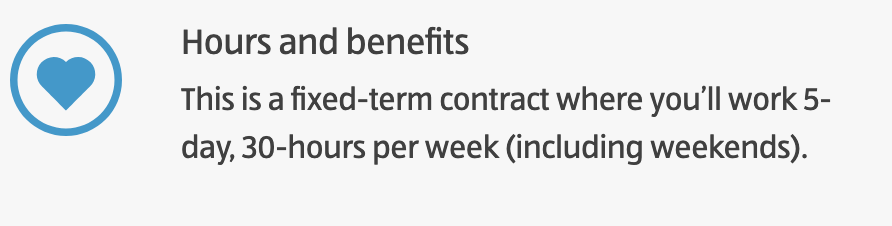
Here, it is "-hours" instead of "-hour"

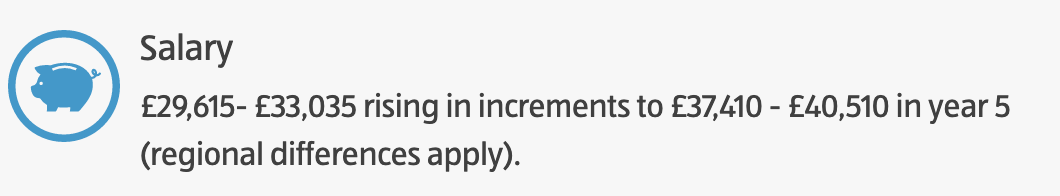
Here, there is a "-" directly attached to one of the numbers

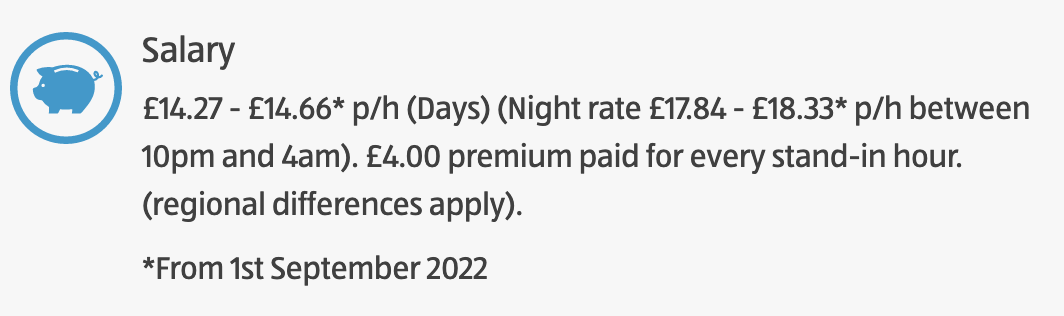
The added "*" makes things complicated

Let's redefine our extraction function to take care of this (look for the comments to see the changes!):

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title)
    details = posting.findAll("div", class_="c-job-details__content")
    ub = "not found"
    lb = "not found"
    work_time = "not found"
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary':
            word_list = detail_text.split()
            number_content = [s for s in word_list if s.startswith('£')]
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('-','') # In some cases, the salary is given as X-Y!
                number = number.replace('*','') # In some cases, the salary has additional information!
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            if len(numbers_formatted) > 0:
                ub = max(numbers_formatted)
                lb = min(numbers_formatted)
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word or '-hours' in word: # Sometimes, it is spelled X-hours instead of X-hour per week
                    word = word.replace('-hours','')
                    word = word.replace('-hour','')
                    work_time = int(word)
    return job_title, lb, ub, work_time

Now we can scrape with more confidence:

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()

And also see our results:

In [ ]:
aldi_job_data

We can now explore the data frame, improve our code if we find issues, and then analyze it. For example, let's have a look at a simple histogram of postings per department.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.histplot(data=aldi_job_data, x="Department",ax=ax)
plt.show()

Finally, save the job postings we found as a CSV:

In [ ]:
aldi_job_data.to_csv('Aldi_postings_2022-10-06.csv', index=False)

## Exercise 1

Can you correct the scraping function to avoid issues with the salary or weekly hour number? Define a new function `scrape_aldi_jobs_corrected`, in which you eliminate any issues you come across in the data.

Note that the below code fixes some issues, but not all.

Looking at the CSV, we see something strange in the salary numbers:

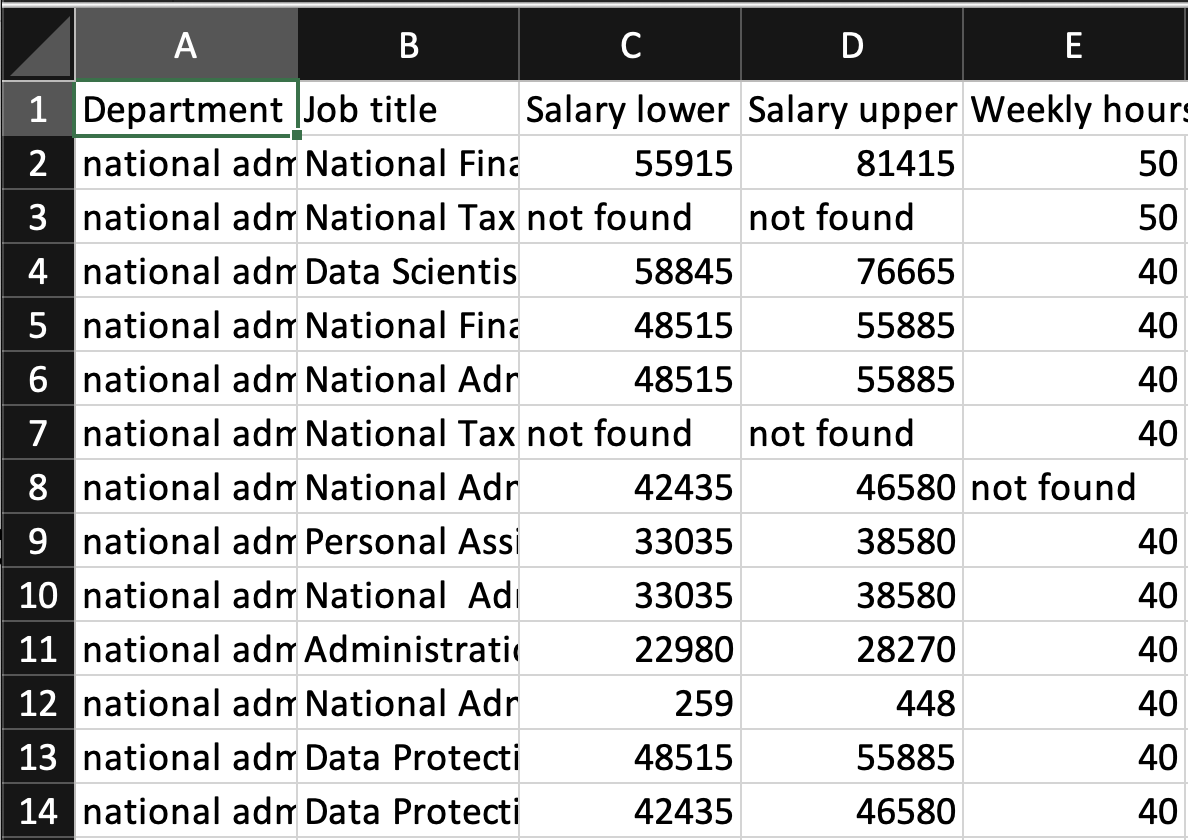

What is happening here? Looking at the postings in question, we immediately find the problem:

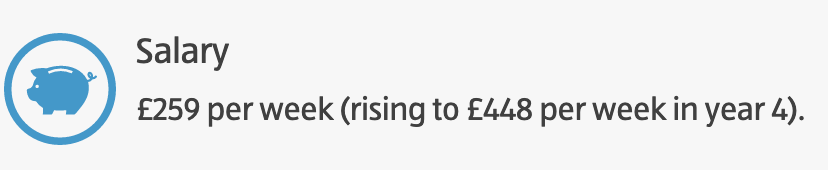
Here, there is a weekly salary.

Let's again redefine the parsing function:

In [ ]:
def extract_posting_details(posting):

    
    
    
    

Let's run our scraping tool again, and take another look:

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()
aldi_job_data.to_csv('Aldi_postings_2022-10-06.csv', index=False)

We can identify another issue at the end of the table:
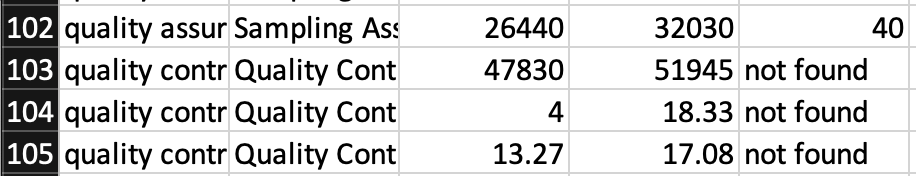

This is similar to before, just that the wages are now per hour:
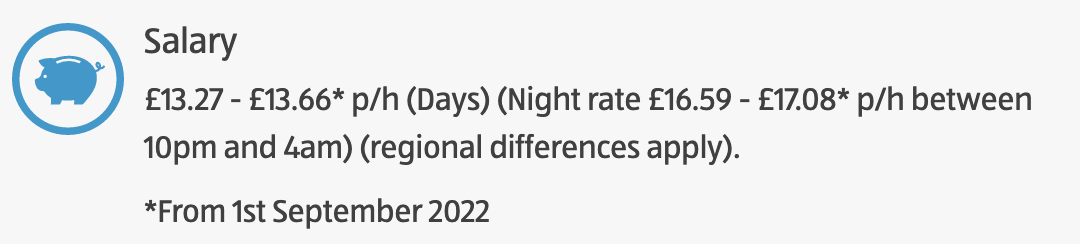

If we would simply assume 40 hours per week, we would get to weird salary comparisons. Here, we have to make sure that we actually compute the salary that someone obtains within a workweek with the given hours.

If we look at the postings, however, we see that the hours are not captured. This is because there is no dash in the hours:
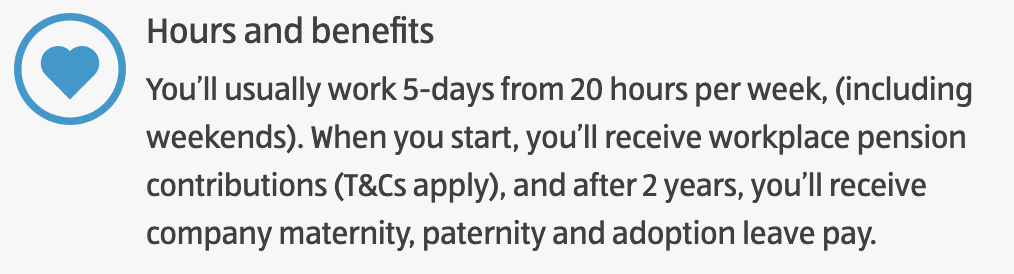

So, we need to also adjust the hour computation some more. Then, the tricky part is that we now need to combine salary and work hour information. As the sequence may be arbitrary, we need to make sure to do so outside of any of the particular parts:

In [ ]:
def extract_posting_details(posting):

    
    
    
    
    
    
    
    

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()
aldi_job_data.to_csv('Aldi_postings_2022-10-06.csv', index=False)

## Exercise 2

The idea is that we run our code regularly and observe the current postings. For this, we need to do the following:
1. Load an existing csv file with job postings (on Moodle)
2. For any job currently found on the website, check whether it was already posted previously (focus on the department and title only)
3. Make sure you collect the date of posting as well

# The problem with Dynamic websites

Say we want to get data from a second competitor. We will use Lidl here (I am, of course, not biased in my choices). Check out Lidl's hiring page https://careers.lidl.co.uk/ and start a search. Then look at the link where you landed at and try scraping it.

In [ ]:
url = "https://careers.lidl.co.uk/jobsearch?page=1&midpoint_name=KT5%209NU&midpoint_lat=51.376535&midpoint_lon=-0.27857&radius=5&filter={%22contract_type%22:[],%22employment_area%22:[%22facility-management%22,%22finance-accounting-tax%22,%22grocery%22,%22hr%22,%22it%22,%22logistics%22,%22pr-marketing%22,%22purchasing%22,%22real-estate%22,%22sales%22,%22supply-chain-management%22],%22entry_level%22:[]}&with_event=true"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

In [ ]:
soup.findAll("h6", class_="jobTitle")